# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2025-06-27 07:10:19.290332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751008219.511236      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751008219.572913      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s5e6/sample_submission.csv
/kaggle/input/playground-series-s5e6/train.csv
/kaggle/input/playground-series-s5e6/test.csv


# Import Data

In [4]:
train_dir = "/kaggle/input/playground-series-s5e6/train.csv"
test_dir = "/kaggle/input/playground-series-s5e6/test.csv"
sample_submission_dir = "/kaggle/input/playground-series-s5e6/sample_submission.csv"

In [5]:
def load_data(directory):
    data = pd.read_csv(directory)
    return data

In [6]:
train_data = load_data(train_dir)
test_data = load_data(test_dir)
sample_submission = load_data(sample_submission_dir)

# Exploratory Data Analysis

Very rough work here. you can skip

In [7]:
train_data.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


In [9]:
train_data.describe()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [10]:
train_data.describe(include='object')

,Soil Type,Crop Type,Fertilizer Name
count,750000,750000,750000
unique,5,11,7
top,Sandy,Paddy,14-35-14
freq,156710,85754,114436


In [11]:
pd.set_option('display.max_rows', None)

In [12]:
num_cols = train_data.select_dtypes(include=np.number).columns.tolist()
num_cols

['id',
 'Temparature',
 'Humidity',
 'Moisture',
 'Nitrogen',
 'Potassium',
 'Phosphorous']

In [13]:
cat_cols = train_data.select_dtypes(include='object').columns.tolist()
cat_cols

['Soil Type', 'Crop Type', 'Fertilizer Name']

In [14]:
for column in cat_cols:
    display(train_data[column].value_counts())

Soil Type
Sandy     156710
Black     150956
Clayey    148382
Red       148102
Loamy     145850
Name: count, dtype: int64

Crop Type
Paddy          85754
Pulses         78180
Cotton         69171
Tobacco        68000
Wheat          66628
Millets        65291
Barley         65045
Sugarcane      64269
Oil seeds      64184
Maize          62569
Ground Nuts    60909
Name: count, dtype: int64

Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64

In [15]:
pd.reset_option('display.max_rows')

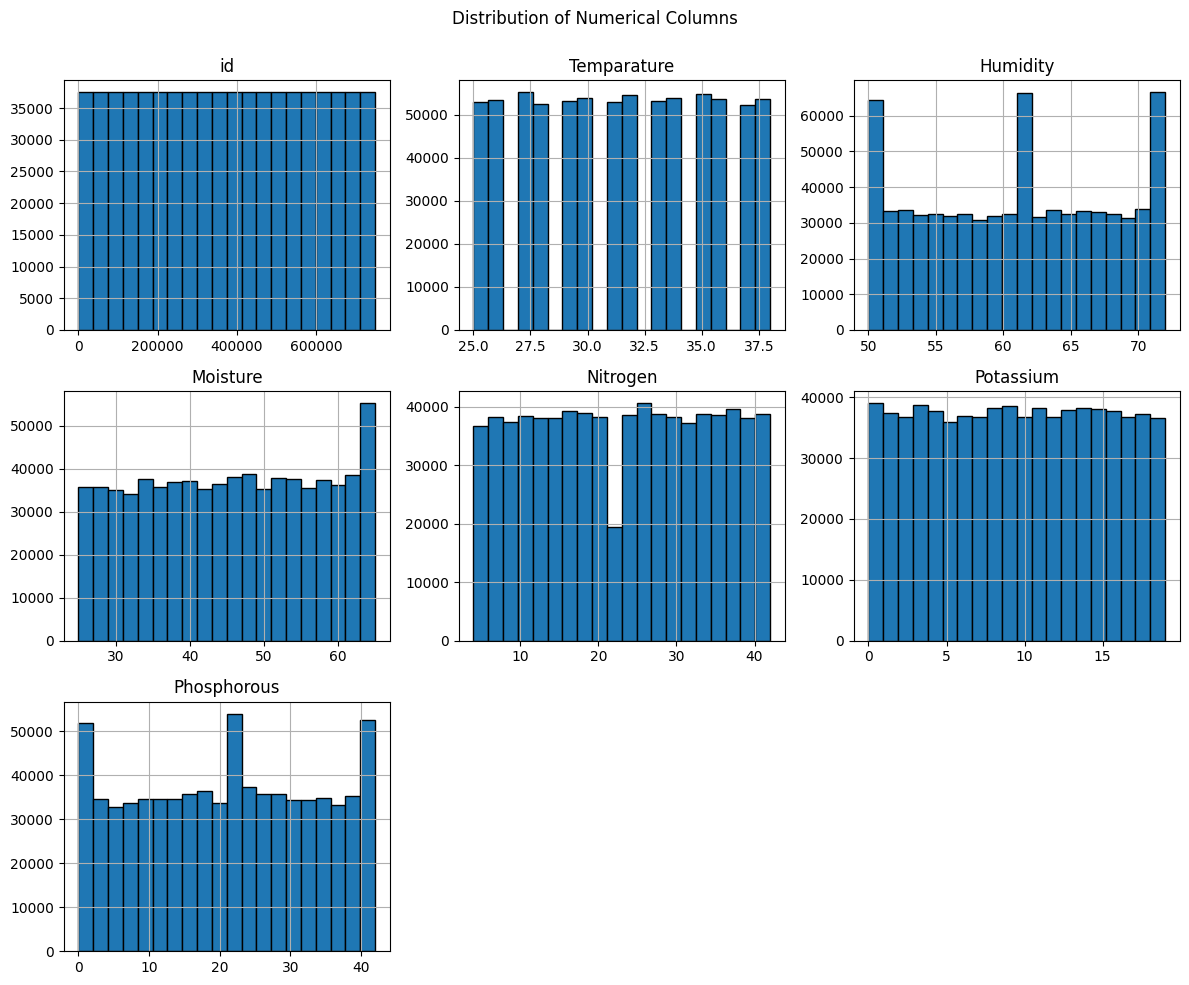

In [16]:
train_data.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Columns')
plt.tight_layout(rect=[0,0,1,0.98])
plt.show()

# Preprocessing 

## Split Data

In [17]:
def split_data(data):
    data = data.dropna()
    X = data.drop(columns=['id', 'Fertilizer Name'])
    y = data['Fertilizer Name']
    return X, y
    

In [18]:
X_train, y_train = split_data(train_data)

## Normalize and create enocodings for features

In [19]:
def preprocess_data(X):
    # Extract numerical columns and categorical columns
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    num_features = X[num_cols]
    num_features_dict = {key: value.to_numpy()[:, tf.newaxis] for key, value in dict(num_features).items()}
    # Preprocessing model 
    inputs={}
    for name, column in X.items():
        if type(column[0]) == str:
            dtype = tf.string
        elif name in cat_cols:
            dtype = tf.int64
        else:
            dtype = tf.float32
        inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
    # Normalize numeric inputs
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.concatenate([value for key, value in sorted(num_features_dict.items())]))
    num_inputs=[]
    for name in num_cols:
        num_inputs.append(inputs[name])
    num_inputs = tf.keras.layers.Concatenate(axis=-1)(num_inputs)
    num_normalized = normalizer(num_inputs)
    preprocessed=[]
    preprocessed.append(num_normalized)
    # Categorical features get encoded to one hot encodings
    for name in cat_cols:
        vocab = sorted(set(X[name]))
        print(f'name: {name}')
        print(f"vocab: {vocab}\n")
        if type(vocab[0]) is str:
            lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
        else:
            lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
        x = inputs[name]
        x = lookup(x)
        preprocessed.append(x)
    preprocessed_result = tf.keras.layers.Concatenate(axis=1)(preprocessed)
    return inputs, preprocessed_result

In [20]:
inputs, preprocessed_result= preprocess_data(X_train)

2025-06-27 07:10:39.756182: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


name: Soil Type
vocab: ['Black', 'Clayey', 'Loamy', 'Red', 'Sandy']

name: Crop Type
vocab: ['Barley', 'Cotton', 'Ground Nuts', 'Maize', 'Millets', 'Oil seeds', 'Paddy', 'Pulses', 'Sugarcane', 'Tobacco', 'Wheat']



In [21]:
preprocessor = tf.keras.Model(inputs, preprocessed_result)

In [22]:
help(tf.keras.utils.plot_model)

Help on function plot_model in module keras.src.utils.model_visualization:

plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=200, show_layer_activations=False, show_trainable=False, **kwargs)
    Converts a Keras model to dot format and save to a file.
    
    Example:
    
    ```python
    inputs = ...
    outputs = ...
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    dot_img_file = '/tmp/model_1.png'
    keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    ```
    
    Args:
        model: A Keras model instance
        to_file: File name of the plot image.
        show_shapes: whether to display shape information.
        show_dtype: whether to display layer dtypes.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot: `"TB"`
            creates

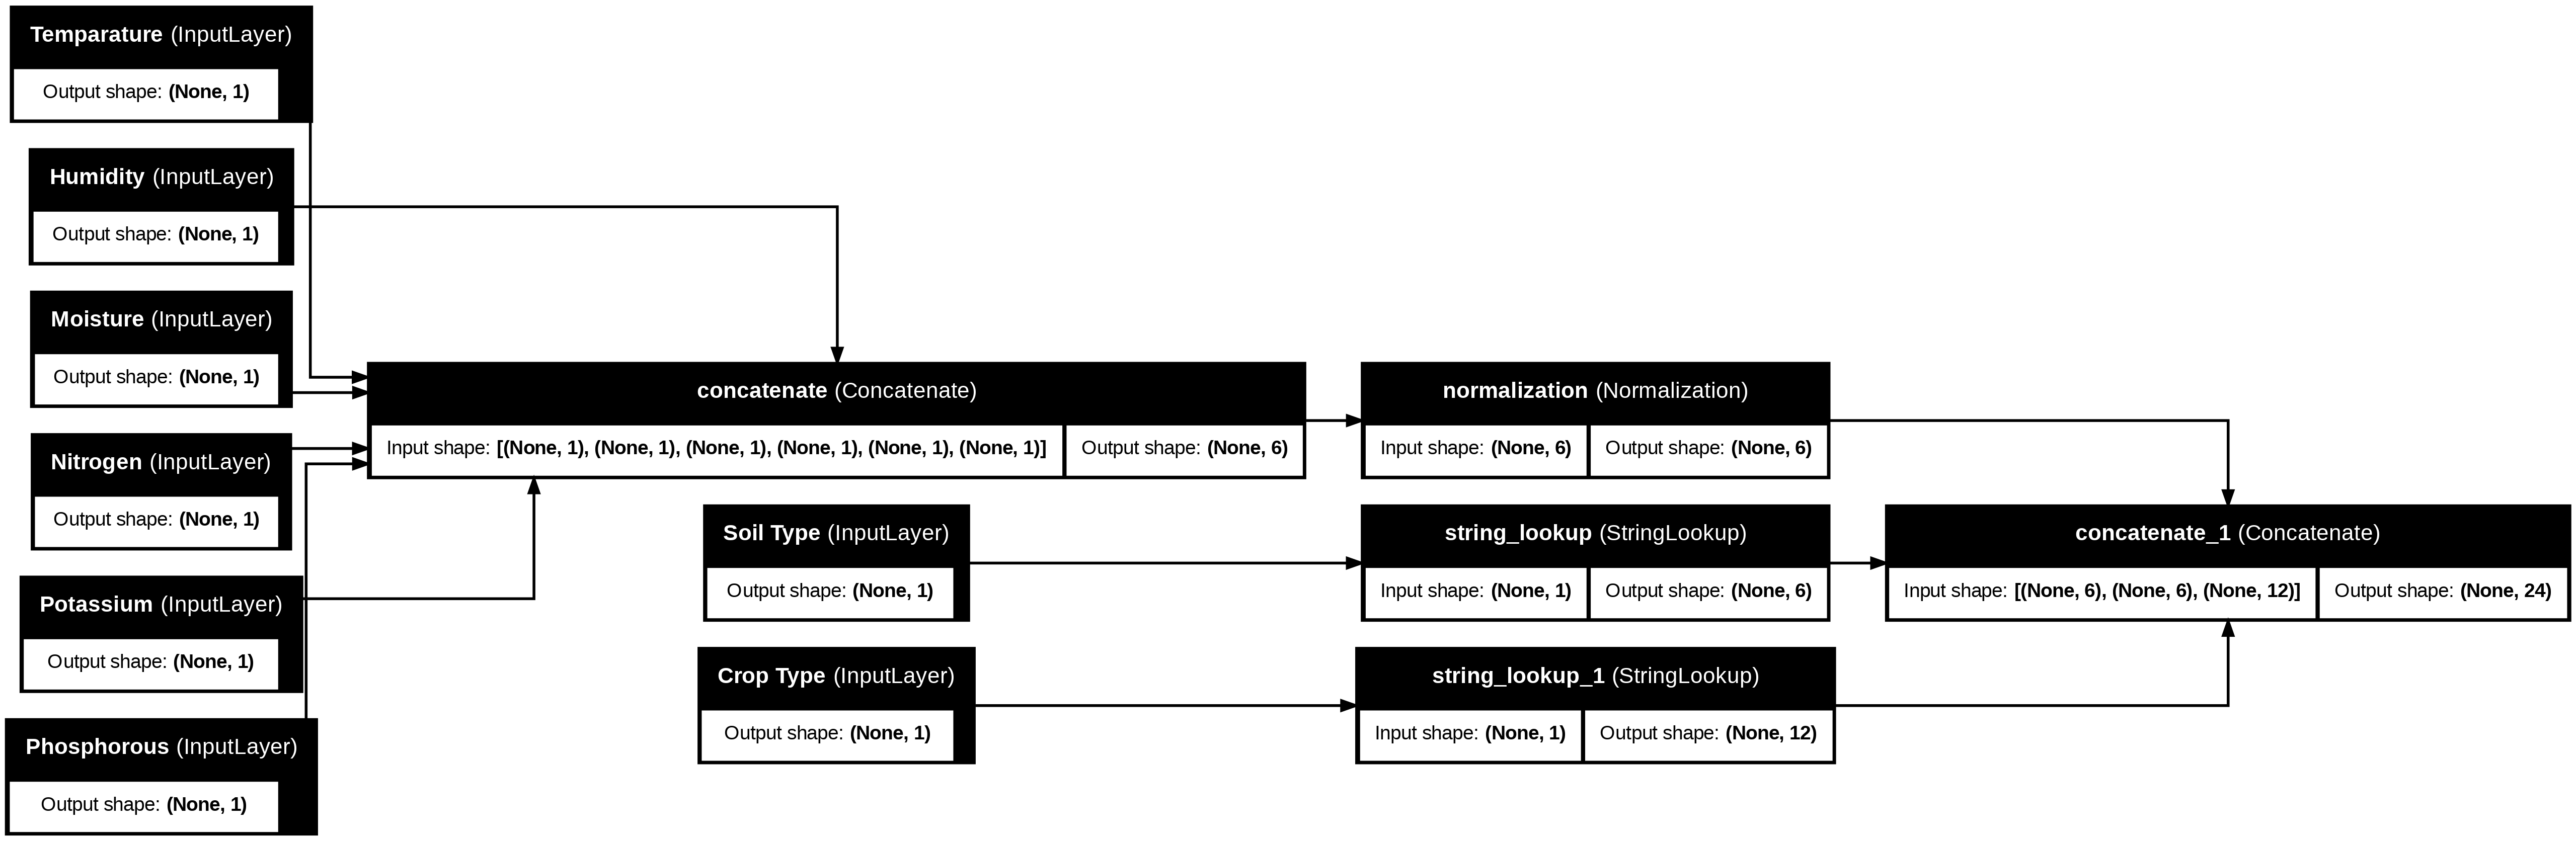

In [23]:
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True,  show_layer_names=True)

## Encodings for label

In [24]:
def process_labels(y_train):
    vocab = sorted(y_train.unique())
    vocab_tensor = tf.constant(vocab)
    lookup_table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(vocab_tensor, tf.range(len(vocab))),
        default_value=-1
    )
    return lookup_table, vocab_tensor

In [25]:
label_lookup, label_vocab = process_labels(y_train)

# Convert labels to one-hot
y_indices = label_lookup.lookup(tf.constant(y_train.values))
y_encoded = tf.one_hot(y_indices, depth=len(label_vocab))

# Model Building

In [26]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(len(label_vocab), activation='softmax')
])

In [27]:
def build_model(inputs=inputs, preprocessor=preprocessor, model=body):
    x = preprocessor(inputs)
    result = body(x)
    model = tf.keras.Model(inputs, result)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])
    return model
    

In [28]:
model = build_model()

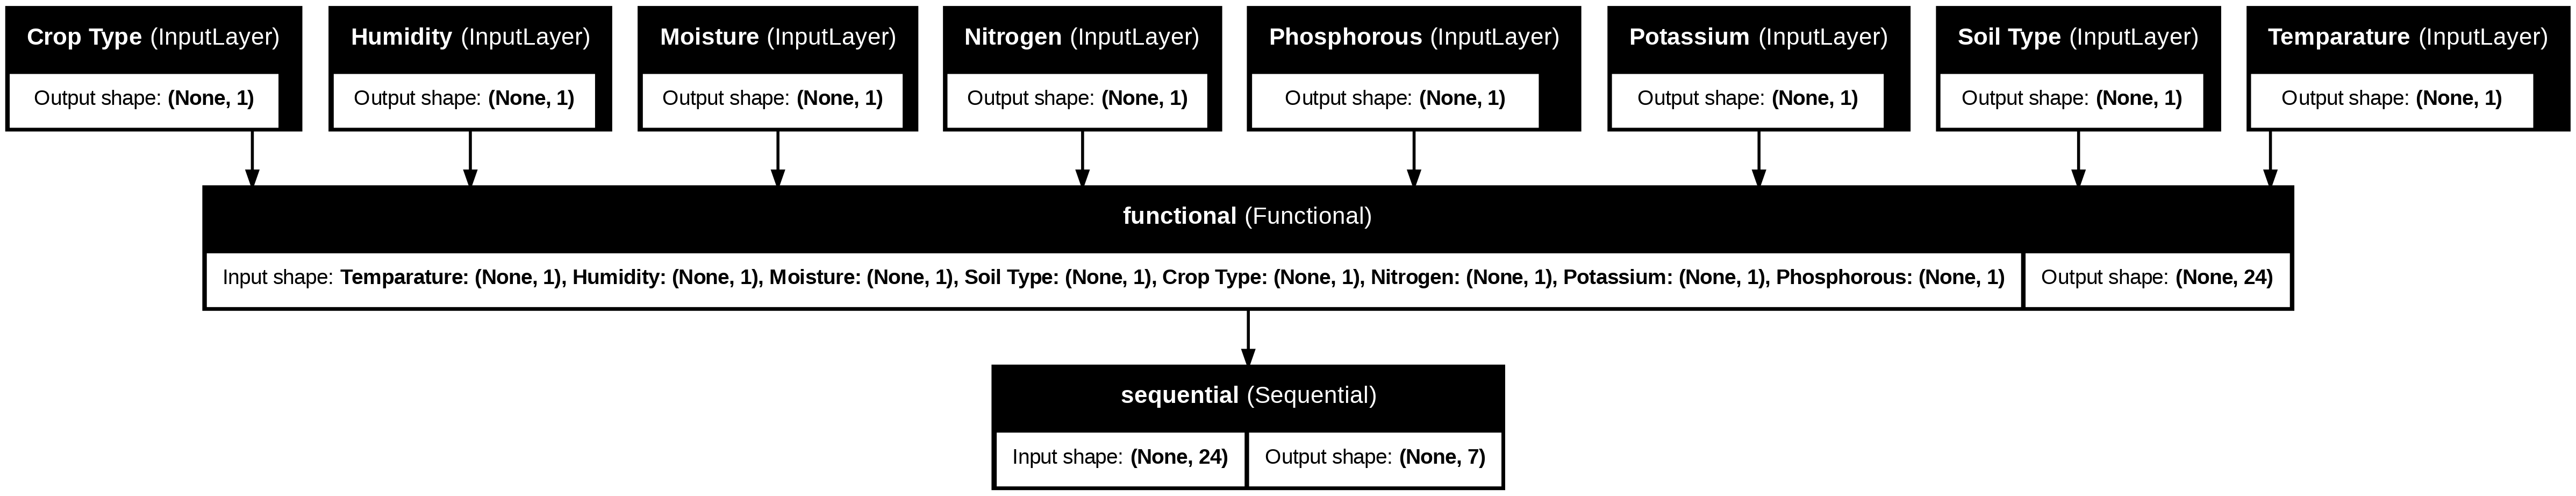

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True,  show_layer_names=True)

# Model Training

In [30]:
ds = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_encoded
))
ds = ds.shuffle(len(y_train)).batch(32)


In [31]:
history = model.fit(ds, epochs=5)

Epoch 1/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.1536 - loss: 1.9422
Epoch 2/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.1570 - loss: 1.9401
Epoch 3/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.1570 - loss: 1.9399
Epoch 4/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.1570 - loss: 1.9398
Epoch 5/5
23438/23438 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.1574 - loss: 1.9395


# Evaluate Model

# Competition submission

In [32]:
# For test predictions
test_data = load_data(test_dir)
X_test = test_data.drop(columns=['id'])

# Convert test data to proper format
test_dict = {}
for name, column in X_test.items():
    if column.dtype == 'object':
        test_dict[name] = column.values
    else:
        test_dict[name] = column.values

# Predict and convert back to original labels
predictions = model.predict(test_dict)
predicted_indices = tf.argmax(predictions, axis=1)
predicted_labels = tf.gather(label_vocab, predicted_indices)

# Convert to numpy for final results
final_predictions = predicted_labels.numpy().astype(str)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


In [33]:
sample_submission

,id,Fertilizer Name
0,750000,14-35-14 10-26-26 Urea
1,750001,14-35-14 10-26-26 Urea
2,750002,14-35-14 10-26-26 Urea
3,750003,14-35-14 10-26-26 Urea
4,750004,14-35-14 10-26-26 Urea
...,...,...
249995,999995,14-35-14 10-26-26 Urea
249996,999996,14-35-14 10-26-26 Urea
249997,999997,14-35-14 10-26-26 Urea
249998,999998,14-35-14 10-26-26 Urea


In [34]:
final_predictions

array(['17-17-17', '20-20', '17-17-17', ..., '14-35-14', '17-17-17',
       '20-20'], dtype='<U8')